Initializing Account and DataFrame
Fetching data...
Initializing plot


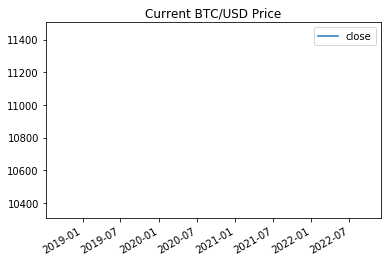

RuntimeError: This event loop is already running

Fetching data...


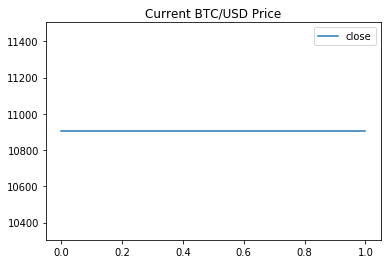

Fetching data...


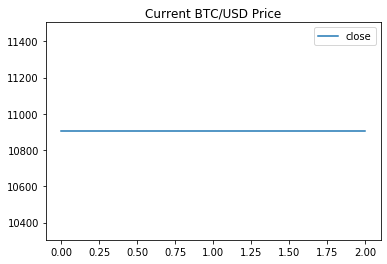

Fetching data...


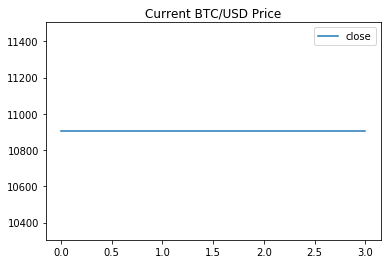

Fetching data...


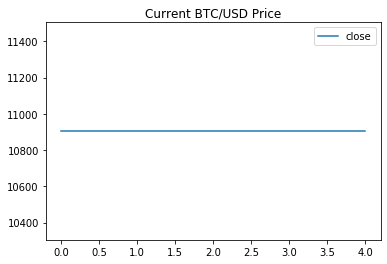

Fetching data...


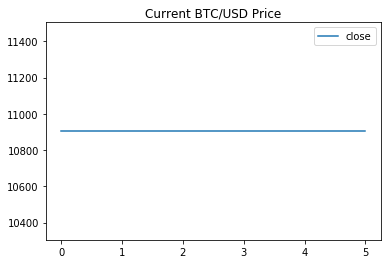

Fetching data...


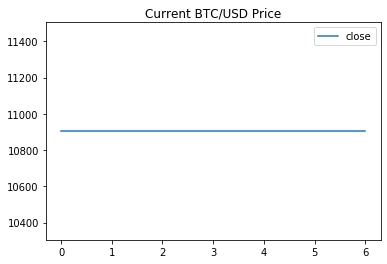

Fetching data...


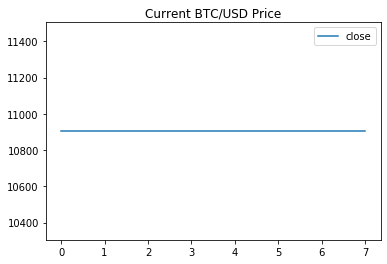

Fetching data...


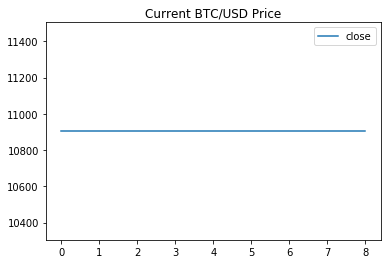

In [1]:
import os
import ccxt
import asyncio
import numpy as np
import pandas as pd
from dotenv import load_dotenv
import matplotlib.pyplot as plt


def initialize(cash=None):
    """Initialize the plot, data storage, and account balances."""
    print("Initializing Account and DataFrame")

    # @TODO: Update to build the plot
    # Initialize Account
    account = {"balance": cash, "shares": 0}

    # Initialize DataFrame
    # @TODO: We will update this later!
    df = fetch_data()

    # Initialize the plot
    build_plot(df)

    # @TODO: We will complete the rest of this later!
    return account, df


def build_plot(df):
    """Build the plot."""

    # @TODO: Build the Initial Plot!
    print("Initializing plot")
    plot = df.plot(title="Current BTC/USD Price")

    return


# @TODO: Create a function to update the plot!
def update_plot(df):
    """Update the plot."""
    plot = df.plot(title="Current BTC/USD Price")

    return


def fetch_data():
    """Fetches the latest prices."""
    print("Fetching data...")
    load_dotenv()
    kraken_public_key = os.getenv("KRAKEN_PUBLIC_KEY")
    kraken_secret_key = os.getenv("KRAKEN_SECRET_KEY")
    kraken = ccxt.kraken({"apiKey": kraken_public_key, "secret": kraken_secret_key})

    close = kraken.fetch_ticker("BTC/USD")["close"]
    datetime = kraken.fetch_ticker("BTC/USD")["datetime"]
    df = pd.DataFrame({"close": [close]})
    df.index = pd.to_datetime([datetime])

    return df


def generate_signals(df):
    """Generates trading signals for a given dataset."""
    print("-----> Generating trading signals <-----")
    # Set window
    short_window = 10

    signals = df.copy()
    signals["signal"] = 0.0

    # Generate the short and long moving averages
    signals["sma10"] = signals["close"].rolling(window=10).mean()
    signals["sma20"] = signals["close"].rolling(window=20).mean()

    # Generate the trading signal 0 or 1,
    signals["signal"][short_window:] = np.where(
        signals["sma10"][short_window:] > signals["sma20"][short_window:], 1.0, 0.0
    )

    # Calculate the points in time at which a position should be taken, 1 or -1
    signals["entry/exit"] = signals["signal"].diff()
    print("-----> Trading signals generated  <-----")

    return signals


def execute_trade_strategy(signals, account):
    """Makes a buy/sell/hold decision."""

    print("**Executing Trading Strategy**")

    if signals["entry/exit"].iloc[-1] == 1.0:
        print("Buy")
        number_to_buy = round(account["balance"] / signals["close"].iloc[-1], 0) * 0.001
        account["balance"] -= number_to_buy * signals["close"].iloc[-1]
        account["shares"] += number_to_buy        
    elif signals["entry/exit"].iloc[-1] == -1.0:
        print("Sell")
        account["balance"] += signals["close"].iloc[-1] * account["shares"]
        account["shares"] = 0
    else:
        print("Hold")
        
    print(f"Account balance: ${account['balance']}")
    print(f"Account shares : {account['shares']}")
    print("**Trading Strategy Executed**")

    return account

# @TODO: Set the initial configurations and update the main loop to use asyncio
# Set the initial account configuration
account, df = initialize(10000)

# Turns on the interactive mode of matplotlib (https://matplotlib.org/api/_as_gen/matplotlib.pyplot.ion.html)
plt.ion()

# Show the initial line chart
plt.show()

async def main():
    loop = asyncio.get_event_loop()

    while True:
        global account
        global df

        # Fetch new prices data
        new_df = await loop.run_in_executor(None, fetch_data)
        df = df.append(new_df, ignore_index=True)

        # Execute the trading strategy
        min_window = 22
        if df.shape[0] >= min_window:
            signals = generate_signals(df)
            account = execute_trade_strategy(signals, account)

        # Update the plot
        update_plot(df)

        # Update line chart
        plt.pause(1)

        # Refresh the matplotlib plotting area to avoid extra memory consumption
        plt.close()

        await asyncio.sleep(1)


# Python 3.7+
loop = asyncio.get_event_loop()
loop.run_until_complete(main())
